In [72]:
from __future__ import print_function
import sdm as sdmlib
from sdm import utils
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
%matplotlib inline

In [104]:
bits = 255
radius = 104 #utils.calculate_radius(bits)
sample = 1000000
scanner_type = sdmlib.SDM_SCANNER_OPENCL

In [105]:
address_space = sdmlib.AddressSpace.init_random(bits, sample)
counter = sdmlib.Counter.init_zero(bits, sample)

In [106]:
sdm = sdmlib.SDM(address_space, counter, radius, scanner_type)

In [107]:
bs_ref = sdmlib.Bitstring.init_random(bits)
sdm.write(bs_ref, bs_ref)

In [108]:
def write(n=1000, prefix=''):
    print('{}Writing {} random bitstrings... '.format(prefix, n), end='')
    for i in range(n):
        if i%20 == 0:
          print('!', end='')
        
        b = sdmlib.Bitstring.init_random(bits)
        sdm.write(b, b)
    print('')
    return n

In [109]:
def calculate_distances(bs, k=6, sample=1, step=1, prefix='', z=None):
    distances = []
    x = range(0, bits+1, step)
    print('{}Calculating distances... '.format(prefix), end='')
    for i, dist in enumerate(x):
        if i%20 == 0:
            print('!', end='')
        v1 = []
        for _ in range(sample):
            c = sdmlib.Bitstring.init_from_bitstring(bs)
            c.flip_random_bits(dist)
            assert c.distance_to(bs) == dist

            v2 = []
            v2.append(c.distance_to(bs))
            d = c
            for j in range(k):
                d = sdm.read(d, z=z)
                v2.append(d.distance_to(bs))
            v1.append(v2)
        distances.append([dist, v1])
    print('')
    return distances

In [110]:
def plot_heatmap(data, iter_readings):
    # Make plot with vertical (default) colorbar
    maxd = int(data.max())
    mind = int(data.min())
    avgd = int ((maxd+mind)/2);
    fig = plt.figure(figsize=(8, 6), dpi=100)
    ax = fig.add_subplot(111)
    
    #use aspect=20 when N=1000
    #use aspect=5 when N=256
    
    from matplotlib.pylab import cm, contourf, contour
    
    cax = ax.imshow(data, cmap=cm.YlGnBu, aspect='auto', interpolation=None, norm=None, origin='lower')
    ax.grid(True, label='Distance')

    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax, ticks=[mind, avgd, maxd]) #had ZERO here before
    cbar.ax.set_yticklabels([str(mind), str(avgd), str(maxd)])
    cbar.ax.set_ylabel(u'Distance obtained after {} iteractive-readings'.format(iter_readings), fontsize=12)
        
    #########CONTOUR DELINEATES THE CRITICAL DISTANCE

    # We are using automatic selection of contour levels;
    # this is usually not such a good idea, because they don't
    # occur on nice boundaries, but we do it here for purposes
    # of illustration.
    #CS = ax.contourf(data, 100, levels=[mind,avgd,maxd], alpha=0.1, cmap=cm.YlGnBu, origin='lower')
    
    # Note that in the following, we explicitly pass in a subset of
    # the contour levels used for the filled contours.  Alternatively,
    # We could pass in additional levels to provide extra resolution,
    # or leave out the levels kwarg to use all of the original levels.
    #CS2 = ax.contour(CS,  levels=[88], colors='gray', origin='lower', hold='on', linestyles='dashdot')
    #CS2 = ax.contour(data,  levels=[1,2,3,4,5,6,7,8,9,10], colors='gray', origin='lower', hold='on', linestyles='dashdot')
    
    plt.title('Critical Distance Behavior', fontsize=20)
    plt.xlabel('Original distance', fontsize=12)
    plt.ylabel('# items previously stored (000\'s)', fontsize=12)
    # Add the contour line levels to the colorbar
    #cbar.add_lines(CS2)
    plt.show()

In [111]:
def get_data(distances, k):
    # k = iterative readings
    
    # [(x, y, z)]
    # x = old distance
    # y = number of writings
    # z = new distance
    data = []
    for writings, v1 in distances:
        v = []
        for old, v2 in v1:
            new = sum(x[k] for x in v2)/len(v2)
            #data.append([old, writings, new])
            v.append(new)
        data.append(v)
    return np.array(data)

In [112]:
def run():
    import time
    start_time = time.time()

    distances = []
    qty = 1000
    n = 10
    step = 1
    sample = 1
    k = 6  # number of iterative readings
    total = 0
    z = 0.5 #None
    for i in range(n):
        prefix = '[{}] '.format(total)

        total += write(qty, prefix=prefix)
        v = calculate_distances(bs_ref, k=k, sample=sample, step=step, prefix=prefix, z=z)
        distances.append((total, v))

        clear_output(wait=True)

        data = get_data(distances, k)
        plot_heatmap(data, k)
        end_time = time.time()
        print('time={:10.0f}  time_per_loop={:5.2f}'.format(end_time - start_time, total/(end_time - start_time)))

    end_time = time.time()

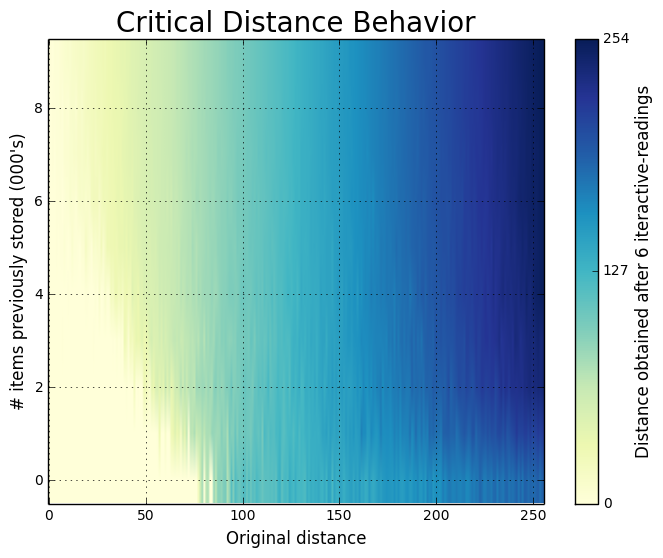

time=       234  time_per_loop=42.83
CPU times: user 3min 11s, sys: 13.9 s, total: 3min 25s
Wall time: 3min 53s


In [113]:
%time run()